In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Review Sentiment Classifier: Multinomial Naive Bayes

The notebook is divided into the following sections:
1. Importing and preprocessing data
2. Building the model: Multinomial Naive Bayes
    - Model building 
    - Model evaluation

### 1. Importing and Preprocessing Data

In [2]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import sklearn
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Capstone_Project_Data/Cell_Phones_and_Accessories_5.csv')
df.head()

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,review_sentiment
0,5.0,True,A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,NaN,NaN,POSITIVE
1,5.0,True,A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,NaN,NaN,POSITIVE
2,3.0,True,AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600,NaN,NaN,NEGATIVE
3,2.0,True,A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000,NaN,NaN,POSITIVE
4,4.0,True,A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600,NaN,NaN,POSITIVE


In [5]:
df = df.loc[~pd.isnull(df['reviewText'])]

In [6]:
len(df.index)

1127669

In [7]:
doc = pd.DataFrame()
doc['reviewText'] = df['reviewText']
doc['reviewSentiment'] = df['review_sentiment']
doc.head()

,reviewText,reviewSentiment
0,Looks even better in person. Be careful to not...,POSITIVE
1,When you don't want to spend a whole lot of ca...,POSITIVE
2,"so the case came on time, i love the design. I...",NEGATIVE
3,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,POSITIVE
4,"I liked it because it was cute, but the studs ...",POSITIVE


In [8]:
sentiment = doc.reviewSentiment.value_counts()
sentiment

POSITIVE    884900
NEGATIVE    242769
Name: reviewSentiment, dtype: int64

In [9]:
print("Postive reviews are about {0}%".format(
    round((sentiment[0]/float(sentiment[0]+sentiment[1]))*100), 2))

Postive reviews are about 78%


In [10]:
doc['label']=doc['reviewSentiment'].map({'POSITIVE':1,'NEGATIVE':0})
doc = doc.drop('reviewSentiment', axis=1)
doc.head()

,reviewText,label
0,Looks even better in person. Be careful to not...,1
1,When you don't want to spend a whole lot of ca...,1
2,"so the case came on time, i love the design. I...",0
3,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,1
4,"I liked it because it was cute, but the studs ...",1


In [11]:
# convert to X and y
X = doc.reviewText
y = doc.label
print(X.shape)
print(y.shape)

(1127669,)
(1127669,)


In [12]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [13]:
# convert messages into list
X_train = [review for review in X_train]
X_test = [review for review in X_test]
print(X_train[0:10])
print(X_test[0:10])

['Good product', "I have had so much trouble with armbands in the past, but this one works like a charm! It doesn't chaff or burn my arm and it fits really snug. The overall desin of the armband is cute, too.", 'works well fast charge I would buy again if need but would like the one that will hold a charge', "Great for bike riding,walking,doing the dishes,etc. . The price was perfect and it's my phone nicely every time. Also arrived early,the Velcro holds very nicely but if you small arms then this will be difficult cause the strap isn't made for small arms. Other than that. I'm glad I bought it.", "I've had the SPIGEN GLAS.t for my iPhone 5 and it was wonderful, which is why i'm so surprised by the subpar quality of this version for the HTC One. First of all the edges aren't beveled like the one for iPhone 5 so you have a very sharp edge that you feel every time you run your finger off the screen. The fit from top to bottom provides nearly 100% coverage of the screen but the side to s

In [14]:
# importing own list of stop words
stop_words_long = [line.rstrip('\n') for line in open('/content/gdrive/MyDrive/Capstone_Project_Data/stop_words_long.txt')]
print(stop_words_long[0:10])
print(len(stop_words_long))

['a', 'about', 'above', 'across', 'after', 'again', 'all', 'almost', 'alone', 'along']
399


In [17]:
stop = list(stopwords.words('english'))
stop.extend(stop_words_long)

In [16]:
wordnet_lemmatizer = WordNetLemmatizer()
def preprocess(document):
    'changes document to lower case and removes stopwords'

    # change sentence to lower case
    document = document.lower()

    # tokenize into words
    words = word_tokenize(document)

    words = [wordnet_lemmatizer.lemmatize(word) for word in words]

    # join words to make sentence
    document = " ".join(words)
    
    return document

X_train = [preprocess(review) for review in X_train]
X_test = [preprocess(review) for review in X_test]
print(X_train[0:10])
print(X_test[0:10])


['good product', "i have had so much trouble with armband in the past , but this one work like a charm ! it doe n't chaff or burn my arm and it fit really snug . the overall desin of the armband is cute , too .", 'work well fast charge i would buy again if need but would like the one that will hold a charge', "great for bike riding , walking , doing the dish , etc . . the price wa perfect and it 's my phone nicely every time . also arrived early , the velcro hold very nicely but if you small arm then this will be difficult cause the strap is n't made for small arm . other than that . i 'm glad i bought it .", "i 've had the spigen glas.t for my iphone 5 and it wa wonderful , which is why i 'm so surprised by the subpar quality of this version for the htc one . first of all the edge are n't beveled like the one for iphone 5 so you have a very sharp edge that you feel every time you run your finger off the screen . the fit from top to bottom provides nearly 100 % coverage of the screen b

In [18]:
# vectorizing the sentences; removing stop words
vectorizer = TfidfVectorizer(analyzer = 'word',stop_words=set(stop))

In [19]:
#fitting the training data into the vectorizer
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'across', 'after', 'again',
                            'against', 'ain', 'all', 'almost', 'alone', 'along',
                            'already', 'also', 'although', 'always', 'am',
                            'among', 'an', 'and', 'another', 'any', 'anybody',
                            'anyone', 'anything', 'anywhere', 'are', 'area',
                            'areas', 'aren', ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [20]:
vectorizer.vocabulary_

{'good': 49093,
 'product': 77077,
 'trouble': 99988,
 'armband': 14886,
 'past': 72691,
 'work': 107071,
 'like': 60883,
 'charm': 28279,
 'doe': 38100,
 'chaff': 27966,
 'burn': 25435,
 'arm': 14869,
 'fit': 45283,
 'snug': 91247,
 'overall': 71577,
 'desin': 36202,
 'cute': 33400,
 'well': 105709,
 'fast': 44278,
 'charge': 28148,
 'buy': 25641,
 'hold': 52379,
 'great': 49700,
 'bike': 22928,
 'riding': 84658,
 'walking': 104922,
 'dish': 37480,
 'etc': 42275,
 'price': 76681,
 'wa': 104752,
 'perfect': 73383,
 'phone': 74005,
 'nicely': 68191,
 'time': 98399,
 'arrived': 15018,
 'velcro': 103582,
 'difficult': 36847,
 'cause': 27552,
 'strap': 93916,
 'glad': 48630,
 'bought': 24196,
 'spigen': 92318,
 'glas': 48672,
 'iphone': 56641,
 'wonderful': 106933,
 'surprised': 95257,
 'subpar': 94435,
 'quality': 78778,
 'version': 103778,
 'htc': 52980,
 'edge': 40339,
 'beveled': 22732,
 'sharp': 88739,
 'feel': 44563,
 'run': 85819,
 'finger': 45065,
 'screen': 87325,
 'top': 98969,
 

In [21]:
# transforming the train and test datasets
X_train_transformed = vectorizer.transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [22]:
# training the Naive Bayes model and making predictions
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train)

# predict class
y_pred_class = mnb.predict(X_test_transformed)

# predict probabilities
y_pred_proba = mnb.predict_proba(X_test_transformed)

## Model Evaluation

In [23]:
# printing the overall accuracy
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.8080576621570812

In [24]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[  7303,  53561],
       [   551, 220503]])

In [25]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
TP = confusion[1, 1]

[[  7303  53561]
 [   551 220503]]


In [26]:
sensitivity = TP / float(FN + TP)
print("sensitivity",sensitivity)

sensitivity 0.9975073963827843


In [27]:
specificity = TN / float(TN + FP)
print("specificity",specificity)

specificity 0.11998882754994743


In [28]:
precision = TP / float(TP + FP)
print("precision",precision)
print(metrics.precision_score(y_test, y_pred_class))

precision 0.8045675462665655
0.8045675462665655


In [29]:
print("precision",precision)
print("PRECISION SCORE :",metrics.precision_score(y_test, y_pred_class))
print("RECALL SCORE :", metrics.recall_score(y_test, y_pred_class))
print("F1 SCORE :",metrics.f1_score(y_test, y_pred_class))

precision 0.8045675462665655
PRECISION SCORE : 0.8045675462665655
RECALL SCORE : 0.9975073963827843
F1 SCORE : 0.890708881519153


In [30]:
y_pred_class

array([1, 1, 1, ..., 1, 1, 1])

In [31]:
y_pred_proba

array([[0.03049389, 0.96950611],
       [0.04112353, 0.95887647],
       [0.07131486, 0.92868514],
       ...,
       [0.07219965, 0.92780035],
       [0.01673852, 0.98326148],
       [0.01984825, 0.98015175]])

In [32]:
# creating an ROC curve
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

In [33]:
# area under the curve
print (roc_auc)

0.9235501034731183


In [34]:
# matrix of thresholds, tpr, fpr
pd.DataFrame({'Threshold': thresholds, 
              'TPR': true_positive_rate, 
              'FPR':false_positive_rate
             })

,Threshold,TPR,FPR
0,1.999811,0.000000,0.000000
1,0.999811,0.000005,0.000000
2,0.999626,0.000018,0.000000
3,0.999575,0.000027,0.000000
4,0.999449,0.000054,0.000000
...,...,...,...
56146,0.000039,0.999995,0.999819
56147,0.000038,0.999995,0.999852
56148,0.000032,1.000000,0.999852
56149,0.000009,1.000000,0.999967


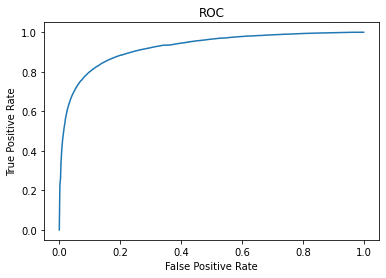

In [35]:
# plotting the ROC curve
%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

## End of Model Evaluation